# Setup & Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [3]:
import config

import pytz
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from datetime import datetime
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
from tqdm.notebook import tqdm as tqdm_notebook

# 1.1. Change size and scope

In [ ]:
pr_df = pd.read_parquet(config.PR_DF_PATH)
pr_commits_df = pd.read_parquet(config.PR_COMMITS_DF_PATH)
pr_commit_details_df = pd.read_parquet(config.PR_COMMIT_DETAILS_DF_PATH)

human_pr_df = pd.read_parquet(config.HUMAN_PR_DF_PATH)
human_pr_commit_details_df = pd.read_parquet(config.HUMAN_PR_COMMIT_DETAILS_DF_PATH)

In [105]:
pr_commit_details_df = pd.read_parquet(config.PR_COMMIT_DETAILS_DF_PATH)

In [6]:
pr_commits_df = pd.read_parquet(config.PR_COMMITS_DF_PATH)

In [7]:
human_pr_df = pd.read_parquet(config.HUMAN_PR_DF_PATH)

In [104]:
human_pr_commit_details_df = pd.read_parquet(config.HUMAN_PR_COMMIT_DETAILS_DF_PATH)

In [4]:
pr_df = pd.read_parquet(config.PR_DF_PATH)

In [176]:
def load_pr_df_for_1_1_analysis(pr_df: pd.DataFrame) -> pd.DataFrame:
    pr_df = pr_df[['id', 'agent', 'created_at', 'closed_at', 'merged_at', 'state']]
    pr_df = pr_df.rename(columns={'id': 'pr_id'})
    pr_df['is_merged'] = np.where(pr_df['merged_at'].isna(), 0, 1)
    pr_df = pr_df[pr_df['closed_at'].isnull() == False]

    pr_df['created_at_dt'] = pd.to_datetime(pr_df['created_at'])
    pr_df = pr_df[pr_df['created_at_dt'].between(datetime(2025, 1, 1, tzinfo=pytz.UTC), datetime(2025, 7, 1, tzinfo=pytz.UTC))]
    pr_df.drop('created_at_dt', axis=1, inplace=True)
    logger.info(f"Loaded {pr_df.shape[0]} PRs for 1.1 analysis")
    logger.info(f"Unique PRs: {pr_df['pr_id'].nunique()}")
    return pr_df

In [177]:
def load_human_pr_df_for_1_1_analysis(human_pr_df: pd.DataFrame) -> pd.DataFrame:
    human_pr_df = human_pr_df[['id', 'agent', 'created_at', 'closed_at', 'merged_at', 'state']]
    human_pr_df = human_pr_df.rename(columns={'id': 'pr_id'})
    human_pr_df['is_merged'] = np.where(human_pr_df['merged_at'].isna(), 0, 1)
    human_pr_df = human_pr_df[human_pr_df['closed_at'].isnull() == False]
    
    human_pr_df['created_at_dt'] = pd.to_datetime(human_pr_df['created_at'])
    human_pr_df = human_pr_df[human_pr_df['created_at_dt'].between(datetime(2025, 1, 1, tzinfo=pytz.UTC), datetime(2025, 7, 1, tzinfo=pytz.UTC))]
    human_pr_df.drop('created_at_dt', axis=1, inplace=True)
    logger.info(f"Loaded {human_pr_df.shape[0]} PRs for 1.1 analysis")
    logger.info(f"Unique human PRs: {human_pr_df['pr_id'].nunique()}")
    return human_pr_df

In [178]:
pr_df_1_1 = load_pr_df_for_1_1_analysis(pr_df)

2025-11-06 16:24:20.547 | INFO     | __main__:load_pr_df_for_1_1_analysis:10 - Loaded 19196 PRs for 1.1 analysis
2025-11-06 16:24:20.548 | INFO     | __main__:load_pr_df_for_1_1_analysis:11 - Unique PRs: 19196


In [179]:
pr_df_1_1.head(1)

,pr_id,agent,created_at,closed_at,merged_at,state,is_merged
27,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0


In [180]:
human_pr_df_1_1 = load_human_pr_df_for_1_1_analysis(human_pr_df)

2025-11-06 16:24:20.899 | INFO     | __main__:load_human_pr_df_for_1_1_analysis:10 - Loaded 6149 PRs for 1.1 analysis
2025-11-06 16:24:20.900 | INFO     | __main__:load_human_pr_df_for_1_1_analysis:11 - Unique human PRs: 6149


In [181]:
human_pr_df_1_1.head(1)

,pr_id,agent,created_at,closed_at,merged_at,state,is_merged
0,2336888723,Human,2025-02-14T19:04:59Z,2025-02-18T22:42:20Z,2025-02-18T22:42:19Z,closed,1


In [182]:
def load_pr_commit_details_df_for_1_1_analysis(pr_commit_details_df: pd.DataFrame) -> pd.DataFrame:
    pr_commit_details_df = pr_commit_details_df[['pr_id', 'sha', 'filename', 'status', 'changes', 'additions', 'deletions']]
    logger.info(f"Loaded {pr_commit_details_df.shape[0]} PR commits for 1.1 analysis")
    logger.info(f"Unique PR commits: {pr_commit_details_df['pr_id'].nunique()}")
    return pr_commit_details_df

In [183]:
pr_commit_details_df_1_1 = load_pr_commit_details_df_for_1_1_analysis(pr_commit_details_df)
pr_commit_details_df_1_1.head(1)

2025-11-06 16:24:21.502 | INFO     | __main__:load_pr_commit_details_df_for_1_1_analysis:3 - Loaded 711923 PR commits for 1.1 analysis
2025-11-06 16:24:21.505 | INFO     | __main__:load_pr_commit_details_df_for_1_1_analysis:4 - Unique PR commits: 33580


,pr_id,sha,filename,status,changes,additions,deletions
0,3271196926,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,.github/workflows/compile-llms-txt.yml,added,38.0,38.0,0.0


In [184]:
def load_human_pr_commit_details_df_for_1_1_analysis(human_pr_commit_details_df: pd.DataFrame) -> pd.DataFrame:
    human_pr_commit_details_df = human_pr_commit_details_df[['pr_id', 'sha', 'file', 'status', 'changes', 'additions', 'deletions']]
    human_pr_commit_details_df = human_pr_commit_details_df.rename(columns={'file': 'filename'})
    logger.info(f"Loaded {human_pr_commit_details_df.shape[0]} human PR commits for 1.1 analysis")
    logger.info(f"Unique human PR commits: {human_pr_commit_details_df['pr_id'].nunique()}")
    return human_pr_commit_details_df

In [185]:
human_pr_commit_details_df_1_1 = load_human_pr_commit_details_df_for_1_1_analysis(human_pr_commit_details_df)
human_pr_commit_details_df_1_1.head(1)

2025-11-06 16:24:23.164 | INFO     | __main__:load_human_pr_commit_details_df_for_1_1_analysis:4 - Loaded 315472 human PR commits for 1.1 analysis
2025-11-06 16:24:23.166 | INFO     | __main__:load_human_pr_commit_details_df_for_1_1_analysis:5 - Unique human PR commits: 6603


,pr_id,sha,filename,status,changes,additions,deletions
0,2354816036,f76ad8971b774e58f2dd71fbdcb0cc669c1ab7f6,Cargo.lock,modified,1,1,0


In [186]:
def form_df_for_1_1_analysis(pr_df, pr_commit_details_df, human_pr_df, human_pr_commit_details_df):
    ai_combined = pr_df.merge(pr_commit_details_df, on='pr_id', how='inner')
    logger.info(f"There are {pr_df['pr_id'].nunique() - ai_combined['pr_id'].nunique()} PRs not found in pr_commit_details_df") # only 33580 PRs in pr_commit_details_df
    human_combined = human_pr_df.merge(human_pr_commit_details_df, on='pr_id', how='inner')
    logger.info(f"There are {human_pr_df['pr_id'].nunique() - human_combined['pr_id'].nunique()} PRs not found in human_pr_commit_details_df")
    result = pd.concat([ai_combined, human_combined], ignore_index=True)
    return result

In [187]:
df = form_df_for_1_1_analysis(pr_df_1_1, pr_commit_details_df_1_1, human_pr_df_1_1, human_pr_commit_details_df_1_1) # there are some PRs with no commit details.

2025-11-06 16:24:23.751 | INFO     | __main__:form_df_for_1_1_analysis:3 - There are 9 PRs not found in pr_commit_details_df
2025-11-06 16:24:23.785 | INFO     | __main__:form_df_for_1_1_analysis:5 - There are 14 PRs not found in human_pr_commit_details_df


In [188]:
df.head(2)

,pr_id,agent,created_at,closed_at,merged_at,state,is_merged,sha,filename,status,changes,additions,deletions
0,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0,82aa5b5577c29ab1fa5d17e9fa0a6d6d9f54a5c5,linux/pkg/api/raw_websocket.go,added,222.0,222.0,0.0
1,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0,82aa5b5577c29ab1fa5d17e9fa0a6d6d9f54a5c5,linux/pkg/api/server.go,modified,12.0,12.0,0.0


In [189]:
def add_is_agent_column(df):
    df['is_agent'] = np.where(df['agent'] == 'Human', 0, 1)
    return df

def add_ym_column(df):
    df['created_at_dt'] = pd.to_datetime(df['created_at'])
    df['created_at_ym'] = df['created_at_dt'].dt.strftime('%Y-%m')
    df.drop('created_at_dt', axis=1, inplace=True)
    return df

In [190]:
df = add_is_agent_column(df)
df = add_ym_column(df)
df.head(2)

,pr_id,agent,created_at,closed_at,merged_at,state,is_merged,sha,filename,status,changes,additions,deletions,is_agent,created_at_ym
0,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0,82aa5b5577c29ab1fa5d17e9fa0a6d6d9f54a5c5,linux/pkg/api/raw_websocket.go,added,222.0,222.0,0.0,1,2025-06
1,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0,82aa5b5577c29ab1fa5d17e9fa0a6d6d9f54a5c5,linux/pkg/api/server.go,modified,12.0,12.0,0.0,1,2025-06


In [191]:
def add_module_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['_path_parts'] = df['filename'].str.split('/')
    condition_l1 = df['_path_parts'].str.len() >= 2
    df['module_l1'] = np.nan
    df.loc[condition_l1, 'module_l1'] = df.loc[condition_l1, '_path_parts'].str[-2]
    
    condition_l2 = df['_path_parts'].str.len() >= 3
    df['module_l2'] = np.nan
    df.loc[condition_l2, 'module_l2'] = df.loc[condition_l2, '_path_parts'].str[-3]
    
    df.drop('_path_parts', axis=1, inplace=True)
    return df

In [192]:
df = add_module_columns(df)
df.head(1)

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_50084/2098982215.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['api' 'api' 'session' ... 'login' 'signup' 'src']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[condition_l1, 'module_l1'] = df.loc[condition_l1, '_path_parts'].str[-2]
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_50084/2098982215.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['pkg' 'pkg' 'pkg' ... 'app' 'app' 'web']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[condition_l2, 'module_l2'] = df.loc[condition_l2, '_path_parts'].str[-3]


,pr_id,agent,created_at,closed_at,merged_at,state,is_merged,sha,filename,status,changes,additions,deletions,is_agent,created_at_ym,module_l1,module_l2
0,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0,82aa5b5577c29ab1fa5d17e9fa0a6d6d9f54a5c5,linux/pkg/api/raw_websocket.go,added,222.0,222.0,0.0,1,2025-06,api,pkg


In [481]:
def add_task_type_column(df: pd.DataFrame) -> pd.DataFrame:
    pr_task_type_df = pd.read_parquet(config.PR_TASK_TYPE_DF_PATH)
    human_task_type_df = pd.read_parquet(config.HUMAN_PR_TASK_TYPE_DF_PATH)
    human_task_type_df = human_task_type_df[['id', 'type']]
    pr_task_type_df = pr_task_type_df[['id', 'type']]
    combined_df = pd.concat([human_task_type_df, pr_task_type_df], ignore_index=True)
    combined_df.columns = ['pr_id', 'task_type']
    result_df = df.merge(combined_df, on='pr_id', how='left')
    assert result_df.shape[0] == df.shape[0], "Join must be 1:1" 
    return result_df

In [231]:
df = pd.read_parquet(config.ANALYSIS_1_1_DF_PATH)

In [232]:
df = add_task_type_column(df)
df.head(1)

,pr_id,agent,created_at,closed_at,merged_at,state,is_merged,sha,filename,status,changes,additions,deletions,is_agent,created_at_ym,module_l1,module_l2,task_type
0,3164503419,Claude_Code,2025-06-20T22:47:18Z,2025-06-21T11:51:22Z,None,closed,0,82aa5b5577c29ab1fa5d17e9fa0a6d6d9f54a5c5,linux/pkg/api/raw_websocket.go,added,222.0,222.0,0.0,1,2025-06,api,pkg,fix


In [233]:
df.to_parquet(config.ANALYSIS_1_1_DF_PATH, index=False, engine='pyarrow')

In [234]:
def stats_for_number_pr_merge(df: pd.DataFrame, is_agent: bool = True) -> pd.DataFrame:
    df = df[df['is_agent'] == is_agent]
    grp = df.groupby(['created_at_ym', 'is_merged'])['pr_id'].nunique().unstack().reset_index()
    grp['total_prs'] = grp[0] + grp[1]
    grp['merge_rate'] = grp[1] / grp['total_prs']
    return grp

In [235]:
grp = stats_for_number_pr_merge(df, is_agent=True)
grp


is_merged,created_at_ym,0,1,total_prs,merge_rate
0,2025-01,236,175,411,0.425791
1,2025-02,322,209,531,0.393597
2,2025-03,369,367,736,0.498641
3,2025-04,320,490,810,0.604938
4,2025-05,1399,3999,5398,0.740830
5,2025-06,2250,9051,11301,0.800903


In [236]:
grp = stats_for_number_pr_merge(df, is_agent=False)
grp


is_merged,created_at_ym,0,1,total_prs,merge_rate
0,2025-01,149,755,904,0.835177
1,2025-02,193,767,960,0.798958
2,2025-03,232,863,1095,0.788128
3,2025-04,148,937,1085,0.863594
4,2025-05,176,909,1085,0.837788
5,2025-06,156,850,1006,0.844930


In [237]:
def stats_for_commit_changes(df: pd.DataFrame, is_agent: bool = True) -> pd.DataFrame:
    df = df[df['is_agent'] == is_agent]
    grp_by_pr = df.groupby(['pr_id', 'created_at_ym']).agg({
        'changes': 'sum',
        'additions': 'sum',
        'deletions': 'sum',
        'filename': 'nunique',
        'sha': 'nunique',
        'module_l1': 'nunique',
        'module_l2': 'nunique',
    }).reset_index()
    grp_by_pr.columns = ['pr_id', 'created_at_ym', 'sum_changes', 'additions', 'deletions', 'num_file_changes', 'num_commits', 'num_module_l1', 'num_module_l2']
    
    grp = grp_by_pr.groupby(['created_at_ym']).agg({
        'sum_changes': 'sum',
        'additions': 'sum',
        'deletions': 'sum',
        'num_file_changes': 'mean',
        'num_commits': 'mean',
        'num_module_l1': 'mean',
        'num_module_l2': 'mean',
    }).reset_index()
    
    return grp

In [238]:
grp = stats_for_commit_changes(df, is_agent=True)
grp


,created_at_ym,sum_changes,additions,deletions,num_file_changes,num_commits,num_module_l1,num_module_l2
0,2025-01,2287904.0,1254058.0,1033846.0,23.082725,5.447689,7.571776,4.469586
1,2025-02,1894698.0,1039526.0,855172.0,19.374765,5.657250,7.203390,3.615819
2,2025-03,1191901.0,892883.0,299018.0,24.907609,4.203804,8.330163,4.191576
3,2025-04,1941275.0,1146600.0,794675.0,29.993827,5.293827,10.951852,6.071605
4,2025-05,8210076.0,5109803.0,3100273.0,14.422934,2.684328,4.752130,2.651538
5,2025-06,15910654.0,10337783.0,5572871.0,12.519689,2.299354,3.916733,2.345810


In [239]:
grp['deletions'].sum()

np.float64(11655855.0)

In [240]:
grp = stats_for_commit_changes(df, is_agent=False)
grp


,created_at_ym,sum_changes,additions,deletions,num_file_changes,num_commits,num_module_l1,num_module_l2
0,2025-01,3051883.0,2073975.0,977908.0,35.459071,3.857301,10.490044,5.353982
1,2025-02,3474563.0,2083556.0,1391007.0,35.518750,4.343750,10.870833,5.634375
2,2025-03,3012923.0,1997910.0,1015013.0,38.730594,3.890411,11.579909,6.135160
3,2025-04,3304298.0,1957376.0,1346922.0,33.835023,3.978802,10.626728,6.008295
4,2025-05,5159887.0,3563122.0,1596765.0,31.717972,4.288479,9.037788,5.425806
5,2025-06,2501369.0,1534658.0,966711.0,25.436382,3.299205,7.687873,4.219682


In [362]:
def plot_violin_stats(df: pd.DataFrame) -> None:
    """
    Create split violin plots comparing APR vs HPR for:
    - Changed Files Count
    - Added Lines (log scale)
    - Deleted Lines (log scale)
    
    APR on the right side, HPR on the left side, touching in the middle.
    """
    # Aggregate by PR  
    grp = df.groupby(['pr_id', 'is_agent']).agg(
        {
            'filename': 'nunique',
            'additions': 'sum',
            'deletions': 'sum',
        }
    ).reset_index()
    grp.columns = ['pr_id', 'is_agent', 'num_file_changes', 'total_added_lines', 'total_deleted_lines']
    
    # Map is_agent to group names
    grp['Group'] = grp['is_agent'].map({1: 'APR', 0: 'HPR'})
    
    # Add a dummy category for split violins to share same position
    grp['Category'] = ''  # Single category for all data
    
    # Filter out zero values for log scale plots
    file_changes_nonzero = grp[(grp['num_file_changes'] > 0)]
    added_nonzero = grp[(grp['total_added_lines'] > 0)]
    deleted_nonzero = grp[(grp['total_deleted_lines'] > 0)]
    file_changes_nonzero['Category'] = ''
    added_nonzero['Category'] = ''
    deleted_nonzero['Category'] = ''
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Color palette matching the image
    colors = {'APR': '#E07A7A', 'HPR': '#7AA8D9'}
    
    # Plot 1: Changed Files Count (split violin)
    sns.violinplot(
        data=file_changes_nonzero, 
        x='Category',  # Single category so violins share position
        y='num_file_changes',
        hue='Group',
        hue_order=['HPR', 'APR'],  # HPR left, APR right
        split=True,
        palette=colors,
        ax=axes[0],
        inner='box'
    )
    axes[0].set_xlabel('')
    axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axes[0].set_ylabel('Changed Files Count', fontsize=12)
    axes[0].set_yscale('log')
    axes[0].set_ylim(0.8, file_changes_nonzero['num_file_changes'].max() * 1.5)
    axes[0].grid(True, alpha=0.3)
    axes[0].get_legend().remove()
    
    # Plot 2: Added Lines (log scale, split violin)
    sns.violinplot(
        data=added_nonzero, 
        x='Category',
        y='total_added_lines',
        hue='Group',
        hue_order=['HPR', 'APR'],
        split=True,
        palette=colors,
        ax=axes[1],
        inner='box'
    )
    axes[1].set_xlabel('')
    axes[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axes[1].set_ylabel('Added Lines', fontsize=12)
    axes[1].set_yscale('log')
    axes[1].set_ylim(0.5, added_nonzero['total_added_lines'].max() * 1.5)
    axes[1].grid(True, alpha=0.3)
    axes[1].get_legend().remove()
    
    # Plot 3: Deleted Lines (log scale, split violin)
    sns.violinplot(
        data=deleted_nonzero, 
        x='Category',
        y='total_deleted_lines',
        hue='Group',
        hue_order=['HPR', 'APR'],
        split=True,
        palette=colors,
        ax=axes[2],
        inner='box'
    )
    axes[2].set_xlabel('')
    axes[2].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axes[2].set_ylabel('Deleted Lines', fontsize=12)
    axes[2].set_yscale('log')
    axes[2].set_ylim(0.5, deleted_nonzero['total_deleted_lines'].max() * 1.5)
    axes[2].grid(True, alpha=0.3)
    
    # Keep only the legend from the last plot
    axes[2].legend(title='Group', loc='upper right')
    
    plt.tight_layout()
    plt.show()
    return grp, file_changes_nonzero, added_nonzero, deleted_nonzero

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_50084/3212846296.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_changes_nonzero['Category'] = ''
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_50084/3212846296.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  added_nonzero['Category'] = ''
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_50084/3212846296.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

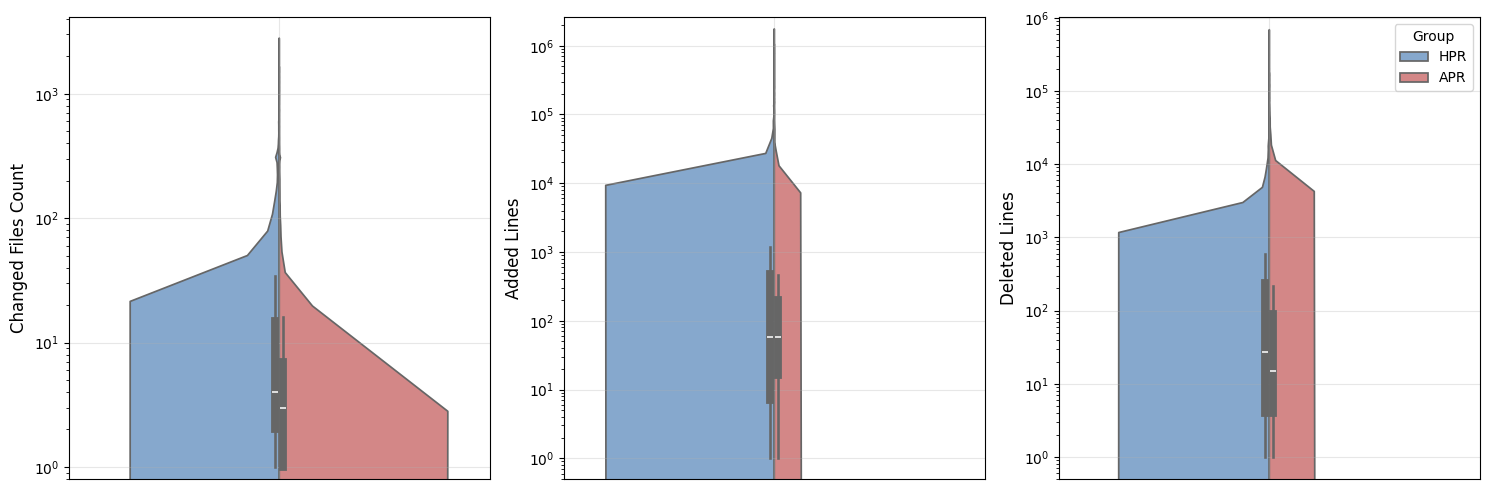

In [363]:
grp, file_changes_nonzero, added_nonzero, deleted_nonzero = plot_violin_stats(df)

In [364]:
deleted_nonzero.groupby('Group')['total_deleted_lines'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
APR,15199.0,766.883019,9317.741820,1.0,4.0,15.0,89.0,682813.0
HPR,5751.0,1268.357851,7035.155561,1.0,4.0,27.0,239.0,175807.0


In [366]:
added_nonzero.groupby('Group')['total_added_lines'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
APR,18728.0,1056.207443,12458.675009,1.0,16.0,59.0,197.00,1053409.0
HPR,6040.0,2187.184934,24209.278555,1.0,7.0,58.0,470.75,1744040.0


In [367]:
file_changes_nonzero.groupby('Group')['num_file_changes'].describe()


,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
APR,18925.0,14.887292,54.008446,1.0,1.0,3.0,7.0,1641.0
HPR,6135.0,33.459984,105.601051,1.0,2.0,4.0,15.0,2765.0


In [246]:
grp.head()

,pr_id,is_agent,num_file_changes,total_added_lines,total_deleted_lines,Group,Category
0,2256770133,0,3,135.0,23.0,HPR,
1,2256773596,0,15,2085.0,193.0,HPR,
2,2256777953,0,1,1.0,1.0,HPR,
3,2256824367,0,131,9126.0,7186.0,HPR,
4,2256920866,0,6,124.0,118.0,HPR,


In [368]:
def test_mannwhitneyu(grp: pd.DataFrame, metric: str, alpha: float = 0.05) -> None:
    if 'Group' not in grp.columns:
        raise ValueError("Group column is required for this function.")
    
    grp_a = grp[grp['Group'] == 'APR'][metric]
    grp_b = grp[grp['Group'] == 'HPR'][metric]
    
    u_statistic, p_value = mannwhitneyu(grp_a, grp_b, alternative='two-sided')
    if p_value < alpha:
        logger.success(f"At {alpha} significance level, the difference in {metric} is statistically significant.")
        logger.info(f"P-value: {p_value:.4f}")
    else:
        logger.warning(f"At {alpha} significance level, the difference in {metric} is NOT statistically significant.")
        logger.info(f"P-value: {p_value:.4f}")
    

In [369]:
test_mannwhitneyu(file_changes_nonzero, 'num_file_changes', alpha=0.05)

2025-11-06 22:04:49.859 | SUCCESS  | __main__:test_mannwhitneyu:10 - At 0.05 significance level, the difference in num_file_changes is statistically significant.
2025-11-06 22:04:49.859 | INFO     | __main__:test_mannwhitneyu:11 - P-value: 0.0000


In [370]:
test_mannwhitneyu(added_nonzero, 'total_added_lines', alpha=0.05)

2025-11-06 22:04:53.957 | WARNING  | __main__:test_mannwhitneyu:13 - At 0.05 significance level, the difference in total_added_lines is NOT statistically significant.
2025-11-06 22:04:53.957 | INFO     | __main__:test_mannwhitneyu:14 - P-value: 0.2866


In [371]:
test_mannwhitneyu(deleted_nonzero, 'total_deleted_lines', alpha=0.05)

2025-11-06 22:05:02.311 | SUCCESS  | __main__:test_mannwhitneyu:10 - At 0.05 significance level, the difference in total_deleted_lines is statistically significant.
2025-11-06 22:05:02.312 | INFO     | __main__:test_mannwhitneyu:11 - P-value: 0.0000


In [251]:
def aggregate_to_pr_level(df: pd.DataFrame) -> pd.DataFrame:
    grp = df.groupby(['pr_id', 'is_agent']).agg({
        'sha': 'nunique',
        'module_l1': 'nunique',
    }).reset_index()
    grp.columns = ['pr_id', 'Group', 'num_commits', 'num_module_l1']
    # map 1,0 to HPR, APR
    grp['Group'] = grp['Group'].map({1: 'APR', 0: 'HPR'})
    return grp

In [252]:
grp = aggregate_to_pr_level(df)

In [253]:
test_mannwhitneyu(grp, 'num_commits', alpha=0.05)

2025-11-06 19:04:11.307 | SUCCESS  | __main__:test_mannwhitneyu:10 - At 0.05 significance level, the difference in num_commits is statistically significant.
2025-11-06 19:04:11.308 | INFO     | __main__:test_mannwhitneyu:11 - P-value: 0.0000


In [254]:
test_mannwhitneyu(grp, 'num_module_l1', alpha=0.05)


2025-11-06 19:04:12.903 | SUCCESS  | __main__:test_mannwhitneyu:10 - At 0.05 significance level, the difference in num_module_l1 is statistically significant.
2025-11-06 19:04:12.904 | INFO     | __main__:test_mannwhitneyu:11 - P-value: 0.0000


In [255]:
def stats_task_type(df: pd.DataFrame) -> pd.DataFrame:
    grp = df.groupby(['task_type', 'is_agent']).agg({
        'pr_id': 'nunique',
    }).reset_index()
    grp.columns = ['task_type', 'is_agent', 'num_prs']
    grp['total_prs'] = grp.groupby('is_agent')['num_prs'].transform('sum')
    grp['pr_rate'] = grp['num_prs'] / grp['total_prs']
    return grp

In [256]:
grp = stats_task_type(df)

In [259]:
df.groupby('is_agent')['pr_id'].nunique()

is_agent
0     6135
1    19187
Name: pr_id, dtype: int64

In [263]:
grp.pivot_table(index='task_type', columns='is_agent', values='pr_rate', aggfunc='mean').sort_values(1, ascending=False)

is_agent,0,1
task_type,,
feat,0.284760,0.379528
fix,0.271883,0.253661
docs,0.074654,0.142961
test,0.029014,0.074842
refactor,0.055909,0.073018
chore,0.133170,0.031271
build,0.096007,0.017356
ci,0.015811,0.009538
perf,0.012062,0.009277


In [510]:
def test_mannwhitneyu_new(grp: pd.DataFrame, column: str, metric: str, groupa: str, groupb: str, alpha: float = 0.05) -> None:
    if column not in grp.columns:
        raise ValueError(f"{column} is not in the dataframe.")
    
    grp_a = grp[grp[column] == groupa][metric]
    grp_b = grp[grp[column] == groupb][metric]
    
    u_statistic, p_value = mannwhitneyu(grp_a, grp_b, alternative='two-sided')
    if p_value < alpha:
        logger.success(f"At {alpha} significance level, the difference in {metric} is statistically significant.")
        logger.info(f"P-value: {p_value:.4f}")
    else:
        logger.warning(f"At {alpha} significance level, the difference in {metric} is NOT statistically significant.")
        logger.info(f"P-value: {p_value:.4f}")
    

In [300]:
check = df.copy()

In [301]:
check['task_type_new'] = check['task_type'].map({
        'build': 'build & chore',
        'chore': 'build & chore',
        'test': 'test & docs',
        'docs': 'test & docs',
    })

In [291]:
def stats_commits_by_task_type(df: pd.DataFrame) -> pd.DataFrame:
    df['task_type_new'] = df['task_type'].map({
        'build': 'build & chore',
        'chore': 'build & chore',
        'test': 'test & docs',
        'docs': 'test & docs',
    })
    agg_to_pr_level = df.groupby(['pr_id', 'task_type_new']).agg({
        'filename': 'nunique',
        'additions': 'sum',
        'deletions': 'sum',
    }).reset_index()

    agg_to_pr_level.columns = ['pr_id', 'task_type', 'num_file_changes', 'additions', 'deletions']

    return agg_to_pr_level

In [353]:
grp_nonzero.groupby('Group')['total_deleted_lines'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
APR,15014.0,770.719395,9365.012042,1.0,4.0,15.0,89.0,682813.0
HPR,5668.0,1246.580628,6896.923918,1.0,4.0,27.0,243.0,175807.0


In [296]:
grp = stats_commits_by_task_type(df)

In [298]:
grp.head()

,pr_id,task_type,num_file_changes,additions,deletions
0,2256777953,build & chore,1,1.0,1.0
1,2257022379,build & chore,1,1.0,1.0
2,2257025799,build & chore,2,169.0,137.0
3,2257213950,build & chore,1,1.0,1.0
4,2257308227,build & chore,1,1.0,1.0


In [289]:
test_mannwhitneyu_new(grp, 'task_type', 'num_file_changes', 'build & chore', 'test & docs', alpha=0.05)

2025-11-06 20:46:54.985 | SUCCESS  | __main__:test_mannwhitneyu_new:10 - At 0.05 significance level, the difference in num_file_changes is statistically significant.
2025-11-06 20:46:54.986 | INFO     | __main__:test_mannwhitneyu_new:11 - P-value: 0.0001


In [344]:
grp[grp['num_file_changes'] > 1000]

,pr_id,task_type,num_file_changes,additions,deletions
509,2343922182,build & chore,1164,48604.0,32362.0
637,2366301215,build & chore,1009,90592.0,10120.0
4673,3119512382,build & chore,1417,58821.0,39658.0
6815,3178456167,test & docs,1060,30315.0,50096.0


In [ ]:
pr_df[pr_df['id'] == 2343922182]['html_url'].values

array([], dtype=object)

In [347]:
human_pr_df[human_pr_df['id'] == 2343922182]['html_url'].values

array(['https://github.com/Azure/azure-sdk-for-js/pull/33127'],
      dtype=object)

In [341]:
human_pr_commit_details_df[human_pr_commit_details_df['pr_id'] == 3119512382].shape

(0, 12)

In [318]:
pr_df.head()

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,None,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...
4,3265782173,17625,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,Claude_Code,47593288,adust09,open,2025-07-26T15:02:48Z,None,None,537233603,https://api.github.com/repos/paradigmxyz/reth,https://github.com/paradigmxyz/reth/pull/17625


In [322]:
human_pr_df[human_pr_df['id'] == 2366301215]['html_url'].values

array(['https://github.com/Azure/azure-rest-api-specs/pull/32930'],
      dtype=object)

In [290]:
grp.groupby('task_type')['num_file_changes'].describe()

,count,mean,std,min,25%,50%,75%,max
task_type,,,,,,,,
build & chore,2339.0,21.073536,78.455584,0.0,1.0,2.0,7.0,1417.0
test & docs,1614.0,13.175960,51.540750,0.0,1.0,2.0,6.0,784.0


In [303]:
test_mannwhitneyu_new(grp, 'task_type', 'additions', 'build & chore', 'test & docs', alpha=0.05)

2025-11-06 20:52:01.376 | SUCCESS  | __main__:test_mannwhitneyu_new:10 - At 0.05 significance level, the difference in additions is statistically significant.
2025-11-06 20:52:01.377 | INFO     | __main__:test_mannwhitneyu_new:11 - P-value: 0.0000


In [304]:
grp.groupby('task_type')['additions'].describe()

,count,mean,std,min,25%,50%,75%,max
task_type,,,,,,,,
build & chore,2339.0,1338.922617,9931.779803,0.0,3.0,17.0,163.5,331256.0
test & docs,4815.0,844.989200,15843.056447,0.0,10.0,36.0,122.0,1053409.0


In [305]:
test_mannwhitneyu_new(grp, 'task_type', 'deletions', 'build & chore', 'test & docs', alpha=0.05)
grp.groupby('task_type')['deletions'].describe()


2025-11-06 20:53:17.899 | SUCCESS  | __main__:test_mannwhitneyu_new:10 - At 0.05 significance level, the difference in deletions is statistically significant.
2025-11-06 20:53:17.899 | INFO     | __main__:test_mannwhitneyu_new:11 - P-value: 0.0000


,count,mean,std,min,25%,50%,75%,max
task_type,,,,,,,,
build & chore,2339.0,1182.042753,9022.360482,0.0,2.0,11.0,118.5,312167.0
test & docs,4815.0,322.769055,2429.741452,0.0,0.0,2.0,21.0,97421.0


# 1.2 Code Quality 

Through the lens of PRs

## Churn code rate

In [562]:
EXT_TO_LANG = {
    ".py": "python",
    ".pyi": "python",
    ".pyw": "python",

    ".js": "javascript",
    ".jsx": "javascript",
    ".mjs": "javascript",
    ".cjs": "javascript",

    ".ts": "typescript",
    ".tsx": "typescript",
    
    ".go": "go",
}


def detect_lang_from_filename(filename: str):
    """Detect programming language from filename extension."""
    _, ext = os.path.splitext(filename.lower())
    return EXT_TO_LANG.get(ext)


In [149]:
# ============================================================================
# STRING-BASED FUNCTION/CLASS EXTRACTION FROM PATCH DIFFS
# ============================================================================

def extract_functions(patch: str, language: str, prefix: str) -> set:
    """
    Extract functions from patch lines with given prefix ('+' or '-').
    
    Args:
        patch: Unified diff string
        language: Programming language (python, javascript, typescript, go)
        prefix: '+' for added functions, '-' for removed functions
        
    Returns:
        set: Function names
    """
    funcs = set()
    
    for line in patch.splitlines():
        if language == 'python':
            if line.startswith(f'{prefix}def '):
                name = line.split('def ', 1)[1].split('(')[0].strip()
                if name:
                    funcs.add(name)
                    
        elif language in ['javascript', 'typescript']:
            if line.startswith(f'{prefix}function '):
                name = line.split('function ', 1)[1].split('(')[0].strip()
                if name:
                    funcs.add(name)
            elif line.startswith(prefix) and '=>' in line:
                parts = line.split('=')
                if len(parts) >= 2:
                    stripped = parts[0].strip()
                    if stripped.startswith(f'{prefix}const '):
                        name = stripped.replace(f'{prefix}const', '').strip()
                        if name:
                            funcs.add(name)
                    elif stripped.startswith(f'{prefix}let '):
                        name = stripped.replace(f'{prefix}let', '').strip()
                        if name:
                            funcs.add(name)
                            
        elif language == 'go':
            if line.startswith(f'{prefix}func '):
                name = line.split('func ', 1)[1].split('(')[0].strip()
                if name:
                    funcs.add(name)
    
    return funcs


def extract_classes(patch: str, language: str, prefix: str) -> set:
    """
    Extract classes from patch lines with given prefix ('+' or '-').
    
    Args:
        patch: Unified diff string
        language: Programming language (python, javascript, typescript, go)
        prefix: '+' for added classes, '-' for removed classes
        
    Returns:
        set: Class names
    """
    classes = set()
    
    # Go doesn't have classes
    if language == 'go':
        return classes
    
    for line in patch.splitlines():
        if language == 'python':
            if line.startswith(f'{prefix}class '):
                name = line.split('class ', 1)[1].split('(')[0].split(':')[0].strip()
                if name:
                    classes.add(name)
                    
        elif language in ['javascript', 'typescript']:
            if line.startswith(f'{prefix}class '):
                name = line.split('class ', 1)[1].split('{')[0].strip()
                if name:
                    classes.add(name)
    
    return classes


def extract_changes_from_patch(patch: str, language: str) -> dict:
    """
    Extract added and removed functions/classes from a patch diff.
    
    Args:
        patch: Unified diff string
        language: Programming language (python, javascript, typescript, go)
        
    Returns:
        dict: {
            'added_functions': set(),
            'removed_functions': set(),
            'added_classes': set(),
            'removed_classes': set()
        }
    """
    result = {
        'added_functions': set(),
        'removed_functions': set(),
        'added_classes': set(),
        'removed_classes': set()
    }
    
    if not patch or not language:
        return result
    
    result['added_functions'] = extract_functions(patch, language, '+')
    result['removed_functions'] = extract_functions(patch, language, '-')
    result['added_classes'] = extract_classes(patch, language, '+')
    result['removed_classes'] = extract_classes(patch, language, '-')
    
    return result


def analyze_patch_changes(patch: str, filename: str):
    """
    High-level function to analyze a patch and extract all changes.
    
    Args:
        patch: Unified diff string
        filename: Filename to detect language
        
    Returns:
        dict: Change analysis results
    """
    # Detect language from filename
    language = detect_lang_from_filename(filename)
    
    if not language:
        raise ValueError(f"Language not supported: {filename}")
    
    try:
        changes = extract_changes_from_patch(patch, language)
        changes['language'] = language
    except Exception as e:
        logger.error(f"Error analyzing patch for {filename}: {e}")
        return {
            'language': None,
            'added_functions': set(),
            'removed_functions': set(),
            'added_classes': set(),
            'removed_classes': set(),
            'error': str(e)
        }   
    return changes


def extract_changes_for_df(row):
    """
    Extract function/class changes from a DataFrame row.
    Designed to be used with pandas DataFrame.apply().
    
    Args:
        row: pandas Series with 'patch' and 'filename' columns
        
    Returns:
        pandas Series with 4 columns containing sets:
        - added_functions: set of function names added
        - added_classes: set of class names added  
        - removed_functions: set of function names removed
        - removed_classes: set of class names removed
        
    Usage:
        df[['added_functions', 'added_classes', 'removed_functions', 'removed_classes']] = \\
            df.apply(extract_changes_for_df, axis=1)
            
        # Or with progress bar:
        from tqdm import tqdm
        tqdm.pandas()
        df[['added_functions', 'added_classes', 'removed_functions', 'removed_classes']] = \\
            df.progress_apply(extract_changes_for_df, axis=1)
    """
    # Define column names and order
    cols = ['added_functions', 'added_classes', 'removed_functions', 'removed_classes']
    
    # Handle missing values
    if pd.isna(row['patch']) or pd.isna(row['filename']):
        return pd.Series([set(), set(), set(), set()], index=cols, dtype=object)
    
    try:
        # Detect language from filename
        language = detect_lang_from_filename(row['filename'])
        
        if not language:
            return pd.Series([set(), set(), set(), set()], index=cols, dtype=object)
        
        # Extract changes
        changes = extract_changes_from_patch(row['patch'], language)
        
        # Return as Series with explicit index and dtype
        return pd.Series([
            changes['added_functions'],
            changes['added_classes'],
            changes['removed_functions'],
            changes['removed_classes']
        ], index=cols, dtype=object)
        
    except Exception as e:
        # Log error but don't break the pipeline
        logger.debug(f"Error processing {row.get('filename', 'unknown')}: {e}")
        return pd.Series([set(), set(), set(), set()], index=cols, dtype=object)

In [353]:
def load_human_ai_pr_commit_details_1_2(df: pd.DataFrame, human_df: pd.DataFrame) -> pd.DataFrame:
    '''
    only get those PRs that have patch
    '''
    df = df[['pr_id', 'filename', 'patch', 'status']]
    df = df[df['patch'].isnull() == False]
    df['is_agent'] = 1

    human_df = human_df[human_df['patch'].isnull() == False]
    human_df = human_df[['pr_id', 'file', 'patch', 'status']]
    human_df.columns = ['pr_id', 'filename', 'patch', 'status']
    human_df['is_agent'] = 0

    combined_df = pd.concat([df, human_df], ignore_index=True)
    return combined_df

In [416]:
df_1_2 = load_human_ai_pr_commit_details_1_2(pr_commit_details_df, human_pr_commit_details_df)

In [417]:
df_1_2['prog_lang'] = df_1_2['filename'].apply(detect_lang_from_filename)

In [418]:
df_1_2.head()

,pr_id,filename,patch,status,is_agent,prog_lang
0,3271196926,.github/workflows/compile-llms-txt.yml,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n...",added,1,None
1,3271196926,docs/compile_llms_txt.py,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im...",added,1,python
2,3271196926,docs/compile_llms_txt.py,"@@ -1,47 +1,48 @@\n import os\n from pathlib i...",modified,1,python
3,3271196926,docs/compile_llms_txt.py,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt...",modified,1,python
4,3271196926,docs/compile_llms_txt.py,"@@ -1,29 +1,34 @@\n-import os\n from pathlib i...",modified,1,python


In [419]:
df_1_2 = df_1_2[df_1_2['prog_lang'].isnull() == False]

In [420]:
df_1_2.isnull().sum()/df_1_2.shape[0]

pr_id        0.0
filename     0.0
patch        0.0
status       0.0
is_agent     0.0
prog_lang    0.0
dtype: float64

In [421]:
df_1_2.groupby('prog_lang')['pr_id'].nunique()

prog_lang
go            8013
javascript    3143
python        6292
typescript    9002
Name: pr_id, dtype: int64

In [422]:
df_1_2 = df_1_2.reset_index(drop=True)

In [423]:
df_1_2.shape

(375523, 6)

In [424]:
from tqdm import tqdm
tqdm.pandas(desc="Extracting changes")
df_1_2[['added_functions', 'added_classes', 'removed_functions', 'removed_classes']] = \
    df_1_2.progress_apply(extract_changes_for_df, axis=1)

Extracting changes:   0%|          | 0/375523 [00:00<?, ?it/s]

Extracting changes: 100%|██████████| 375523/375523 [00:26<00:00, 14352.73it/s]


In [425]:
df_1_2.shape

(375523, 10)

In [426]:
df_1_2.head()

,pr_id,filename,patch,status,is_agent,prog_lang,added_functions,added_classes,removed_functions,removed_classes
0,3271196926,docs/compile_llms_txt.py,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im...",added,1,python,{compile_llms_txt},{},{},{}
1,3271196926,docs/compile_llms_txt.py,"@@ -1,47 +1,48 @@\n import os\n from pathlib i...",modified,1,python,{},{},{},{}
2,3271196926,docs/compile_llms_txt.py,"@@ -3,45 +3,60 @@\n \n \n def compile_llms_txt...",modified,1,python,{},{},{},{}
3,3271196926,docs/compile_llms_txt.py,"@@ -1,29 +1,34 @@\n-import os\n from pathlib i...",modified,1,python,{},{},{},{}
4,3271196926,docs/compile_llms_txt.py,"@@ -1,67 +1,154 @@\n+import os\n+import glob\n...",modified,1,python,{},{},{},{}


In [427]:
def combine_func_class(df: pd.DataFrame) -> pd.DataFrame:
    '''each row is a set, combine them into a list'''
    df['added_funcs_classes'] = df[['added_functions', 'added_classes']].apply(lambda x: list(x['added_functions']) + list(x['added_classes']), axis=1)
    df['removed_funcs_classes'] = df[['removed_functions', 'removed_classes']].apply(lambda x: list(x['removed_functions']) + list(x['removed_classes']), axis=1)
    df.drop(columns=['added_functions', 'added_classes', 'removed_functions', 'removed_classes'], inplace=True)
    return df

In [428]:
df_1_2 = combine_func_class(df_1_2)

In [429]:
def aggregate_func_class_to_pr_level(df: pd.DataFrame) -> pd.DataFrame:
    '''aggregate the func/class changes to the PR level'''
    grp = df.groupby(['pr_id', 'is_agent']).agg({
        'added_funcs_classes': 'sum',
        'removed_funcs_classes': 'sum',
    }).reset_index()
    assert grp.shape[0] == grp['pr_id'].nunique() # check key
    return grp

In [445]:
df_1_2_pr_level = aggregate_func_class_to_pr_level(df_1_2)

In [446]:
df_1_2_pr_level.head()

,pr_id,is_agent,added_funcs_classes,removed_funcs_classes
0,2256770133,0,[],[]
1,2256773596,0,[],[]
2,2256824367,0,"[allCachedValues, writeHeapSnapshot, getDefaul...","[writeHeapSnapshot, checkSameOutput, runOn]"
3,2256920866,0,"[downgrade, upgrade]",[]
4,2257291894,0,[],[]


In [447]:
df_1_2_pr_level['added_funcs_classes'] = df_1_2_pr_level.apply(
    lambda row: [item for item in row['added_funcs_classes'] if item not in row['removed_funcs_classes']],
    axis=1
)

In [448]:
df_1_2_pr_level['removed_funcs_classes'] = df_1_2_pr_level.apply(
    lambda row: [item for item in row['removed_funcs_classes'] if item not in row['added_funcs_classes']],
    axis=1
)

In [449]:
# checking the filter
mask = df_1_2_pr_level.apply(
    lambda row: any(item in row['removed_funcs_classes'] for item in row['added_funcs_classes']),
    axis=1
)

conflicts = df_1_2_pr_level[mask]
conflicts.head()

,pr_id,is_agent,added_funcs_classes,removed_funcs_classes


In [450]:
def add_repo_id_and_merged_at_dt(df: pd.DataFrame, pr_df: pd.DataFrame, human_pr_df: pd.DataFrame) -> pd.DataFrame:
    pr_df = pr_df[['id', 'repo_id', 'merged_at']]
    pr_df.columns = ['pr_id', 'repo_id', 'merged_at']
    pr_df['merged_at_dt'] = pd.to_datetime(pr_df['merged_at'])

    human_pr_df = human_pr_df[['id', 'repo_url', 'merged_at']]
    human_pr_df.rename(columns={'id': 'pr_id'}, inplace=True)
    # get last 2 parts of the repo_url
    human_pr_df['repo_id'] = human_pr_df['repo_url'].str.split('/').str[-2:]
    human_pr_df['repo_id'] = human_pr_df['repo_id'].str.join('/')
    human_pr_df.drop('repo_url', axis=1, inplace=True)
    human_pr_df['merged_at_dt'] = pd.to_datetime(human_pr_df['merged_at'])

    combined_pr_df = pd.concat([pr_df, human_pr_df], ignore_index=True)
    df = df.merge(combined_pr_df[['pr_id', 'repo_id', 'merged_at_dt']], on='pr_id', how='left')
    assert df.shape[0] == df['pr_id'].nunique() # check key
    return df

In [451]:
df_1_2_pr_level = add_repo_id_and_merged_at_dt(df_1_2_pr_level, pr_df, human_pr_df)

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_7344/114827190.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_df['merged_at_dt'] = pd.to_datetime(pr_df['merged_at'])
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_7344/114827190.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_pr_df.rename(columns={'id': 'pr_id'}, inplace=True)
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_7344/114827190.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [452]:
df_1_2_pr_level[df_1_2_pr_level['is_agent'] == 0].isnull().sum()

pr_id                      0
is_agent                   0
added_funcs_classes        0
removed_funcs_classes      0
repo_id                    0
merged_at_dt             810
dtype: int64

In [453]:
df_1_2_pr_level = df_1_2_pr_level[df_1_2_pr_level['merged_at_dt'].isnull() == False] ## only consider the merge

In [454]:
df_1_2_pr_level.head()

,pr_id,is_agent,added_funcs_classes,removed_funcs_classes,repo_id,merged_at_dt
2,2256824367,0,"[allCachedValues, getDefaultHeapSnapshotPath]","[writeHeapSnapshot, checkSameOutput, runOn]",oven-sh/bun,2025-01-04 02:39:41+00:00
3,2256920866,0,"[downgrade, upgrade]",[],keephq/keep,2025-01-01 08:13:06+00:00
5,2257308227,0,[],[],antiwork/shortest,2025-01-02 02:39:09+00:00
7,2257382623,0,[],[],promptfoo/promptfoo,2025-01-02 05:36:57+00:00
8,2257424685,0,[],"[test_async_task_execution_call_count, test_do...",crewAIInc/crewAI,2025-01-02 23:35:37+00:00


In [455]:
def form_future_added_removed_funcs_classes(df_1_2_pr_level: pd.DataFrame) -> pd.DataFrame:
    added_df = df_1_2_pr_level[['repo_id', 'pr_id', 'merged_at_dt', 'added_funcs_classes']].explode('added_funcs_classes')
    added_df = added_df[added_df['added_funcs_classes'].isnull() == False]
    # drop duplicates keep first pr_id that introduced the func_class
    added_df = added_df.sort_values(by=['pr_id', 'merged_at_dt'], ascending=True).drop_duplicates(subset=['added_funcs_classes'], keep='first')
    logger.info(f"Total number of unique added func classes: {added_df['added_funcs_classes'].nunique()}")
    logger.info(f"Shape of added_df: {added_df.shape}")
    added_df.columns = ['repo_id', 'added_pr_id', 'added_at_dt', 'func_class']
    assert added_df.shape[0] == added_df[['repo_id', 'added_pr_id', 'func_class']].drop_duplicates().shape[0] # check key

    removed_df = df_1_2_pr_level[['repo_id', 'pr_id', 'merged_at_dt', 'removed_funcs_classes']].explode('removed_funcs_classes')
    removed_df = removed_df[removed_df['removed_funcs_classes'].isnull() == False]
    # drop duplicates keep first pr_id that removed the func_class
    removed_df = removed_df.sort_values(by=['pr_id', 'merged_at_dt'], ascending=True).drop_duplicates(subset=['removed_funcs_classes'], keep='first')
    logger.info(f"Total number of unique removed func classes: {removed_df['removed_funcs_classes'].nunique()}")
    logger.info(f"Shape of removed_df: {removed_df.shape}")
    removed_df.columns = ['repo_id', 'removed_pr_id', 'removed_at_dt', 'func_class']
    assert removed_df.shape[0] == removed_df[['repo_id', 'removed_pr_id', 'func_class']].drop_duplicates().shape[0] # check key


    add_and_move_df = added_df.merge(removed_df, on=['repo_id', 'func_class'], how='inner')
    add_and_move_df = add_and_move_df[add_and_move_df['added_pr_id'] != add_and_move_df['removed_pr_id']]
    add_and_move_df = add_and_move_df[add_and_move_df['added_at_dt'] < add_and_move_df['removed_at_dt']]
    assert add_and_move_df.shape[0] == add_and_move_df[['repo_id', 'func_class', 'added_pr_id', 'removed_pr_id']].drop_duplicates().shape[0] # check key

    df = added_df.merge(
        add_and_move_df[['repo_id', 'func_class', 'added_pr_id', 'removed_pr_id', 'removed_at_dt']], 
        on=['repo_id', 'added_pr_id', 'func_class'], 
        how='left'
    )
    assert df.shape[0] == df[['repo_id', 'added_pr_id', 'func_class']].drop_duplicates().shape[0] # check key
    df['is_removed'] = np.where(df['removed_pr_id'].isnull(), 0, 1)
    df = df.sort_values(by=['repo_id', 'added_pr_id', 'added_at_dt', 'removed_pr_id', 'removed_at_dt'], ascending=False)
    logger.info(f"Shape of df: {df.shape}")
    return df

In [456]:
df_1_2_pr_level.head()

,pr_id,is_agent,added_funcs_classes,removed_funcs_classes,repo_id,merged_at_dt
2,2256824367,0,"[allCachedValues, getDefaultHeapSnapshotPath]","[writeHeapSnapshot, checkSameOutput, runOn]",oven-sh/bun,2025-01-04 02:39:41+00:00
3,2256920866,0,"[downgrade, upgrade]",[],keephq/keep,2025-01-01 08:13:06+00:00
5,2257308227,0,[],[],antiwork/shortest,2025-01-02 02:39:09+00:00
7,2257382623,0,[],[],promptfoo/promptfoo,2025-01-02 05:36:57+00:00
8,2257424685,0,[],"[test_async_task_execution_call_count, test_do...",crewAIInc/crewAI,2025-01-02 23:35:37+00:00


In [457]:
df_1_2_pr_level['pr_id'].nunique()

16794

In [487]:
df_1_2_pr_level_transformed = form_future_added_removed_funcs_classes(df_1_2_pr_level)

2025-11-08 10:58:58.091 | INFO     | __main__:form_future_added_removed_funcs_classes:6 - Total number of unique added func classes: 25951
2025-11-08 10:58:58.091 | INFO     | __main__:form_future_added_removed_funcs_classes:7 - Shape of added_df: (25951, 4)
2025-11-08 10:58:58.107 | INFO     | __main__:form_future_added_removed_funcs_classes:15 - Total number of unique removed func classes: 14490
2025-11-08 10:58:58.107 | INFO     | __main__:form_future_added_removed_funcs_classes:16 - Shape of removed_df: (14490, 4)
2025-11-08 10:58:58.131 | INFO     | __main__:form_future_added_removed_funcs_classes:34 - Shape of df: (25951, 7)


In [488]:
df_1_2_pr_level_transformed.head(2)

,repo_id,added_pr_id,added_at_dt,func_class,removed_pr_id,removed_at_dt,is_removed
9457,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,get_kubernetes_settings,NaN,NaT,0
9458,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,LogFile,NaN,NaT,0


In [489]:
df_1_2_pr_level.head(2)

,pr_id,is_agent,added_funcs_classes,removed_funcs_classes,repo_id,merged_at_dt
2,2256824367,0,"[allCachedValues, getDefaultHeapSnapshotPath]","[writeHeapSnapshot, checkSameOutput, runOn]",oven-sh/bun,2025-01-04 02:39:41+00:00
3,2256920866,0,"[downgrade, upgrade]",[],keephq/keep,2025-01-01 08:13:06+00:00


In [490]:
def get_is_agent_column(df_transformed: pd.DataFrame, df_pr_level: pd.DataFrame) -> pd.DataFrame:
    df_transformed = df_transformed.merge(
        df_pr_level[['pr_id', 'is_agent']], left_on='added_pr_id', right_on='pr_id',
        how='left'
    )
    df_transformed.drop(columns=['pr_id'], axis=1, inplace=True)
    assert df_transformed.shape[0] == df_transformed[['repo_id', 'added_pr_id', 'func_class']].drop_duplicates().shape[0] # check key
    assert df_transformed['is_agent'].isnull().sum() == 0 # check null
    return df_transformed

In [491]:
df_1_2_pr_level_transformed = get_is_agent_column(df_1_2_pr_level_transformed, df_1_2_pr_level)

In [492]:
df_1_2_pr_level_transformed.head()

,repo_id,added_pr_id,added_at_dt,func_class,removed_pr_id,removed_at_dt,is_removed,is_agent
0,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,get_kubernetes_settings,NaN,NaT,0,0
1,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,LogFile,NaN,NaT,0,0
2,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,LogType,NaN,NaT,0,0
3,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,LogLine,NaN,NaT,0,0
4,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,__getattr__,NaN,NaT,0,0


In [ ]:
pr_task_type_df = pd.read_parquet(config.PR_TASK_TYPE_DF_PATH)
human_task_type_df = pd.read_parquet(config.HUMAN_PR_TASK_TYPE_DF_PATH)

In [493]:

def get_add_remove_pr_task_type(df: pd.DataFrame, pr_task_type_df: pd.DataFrame, human_task_type_df: pd.DataFrame) -> pd.DataFrame:
    human_task_type_df = human_task_type_df[['id', 'type']]
    pr_task_type_df = pr_task_type_df[['id', 'type']]

    combined_df = pd.concat([human_task_type_df, pr_task_type_df], ignore_index=True)
    combined_df.columns = ['pr_id', 'task_type']
    
    result_df = df.merge(combined_df, left_on='added_pr_id', right_on='pr_id', how='left')
    result_df.drop(columns=['pr_id'], axis=1, inplace=True)
    result_df.rename(columns={'task_type': 'added_task_type'}, inplace=True)

    result_df = result_df.merge(combined_df, left_on='removed_pr_id', right_on='pr_id', how='left')
    result_df.drop(columns=['pr_id'], axis=1, inplace=True)
    result_df.rename(columns={'task_type': 'removed_task_type'}, inplace=True)

    assert result_df.shape[0] == df.shape[0], "Join must be 1:1" 
    return result_df

In [494]:
df_1_2_pr_level_transformed = get_add_remove_pr_task_type(df_1_2_pr_level_transformed, pr_task_type_df, human_task_type_df)

In [495]:
df_1_2_pr_level_transformed.head()

,repo_id,added_pr_id,added_at_dt,func_class,removed_pr_id,removed_at_dt,is_removed,is_agent,added_task_type,removed_task_type
0,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,get_kubernetes_settings,NaN,NaT,0,0,docs,NaN
1,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,LogFile,NaN,NaT,0,0,docs,NaN
2,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,LogType,NaN,NaT,0,0,docs,NaN
3,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,LogLine,NaN,NaT,0,0,docs,NaN
4,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,__getattr__,NaN,NaT,0,0,docs,NaN


In [496]:
df_1_2_pr_level_transformed['added_batch'] = df_1_2_pr_level_transformed['added_at_dt'].dt.strftime('%Y-%m')

In [497]:
df_1_2_pr_level_transformed.head(2)

,repo_id,added_pr_id,added_at_dt,func_class,removed_pr_id,removed_at_dt,is_removed,is_agent,added_task_type,removed_task_type,added_batch
0,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,get_kubernetes_settings,NaN,NaT,0,0,docs,NaN,2025-06
1,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,LogFile,NaN,NaT,0,0,docs,NaN,2025-06


In [498]:
df_1_2_pr_level_transformed['repo_id'] = df_1_2_pr_level_transformed['repo_id'].astype(str) # solve the error of mixed type, because human repo_id is string
df_1_2_pr_level_transformed.to_parquet(config.ANALYSIS_1_2_1_DF_PATH, index=False, engine='pyarrow')

In [500]:
df_1_2_pr_level_transformed.groupby(['added_batch', 'is_agent', 'is_removed'])['func_class'].nunique().reset_index()

,added_batch,is_agent,is_removed,func_class
0,2024-12,1,0,21
1,2025-01,0,0,1012
2,2025-01,0,1,217
3,2025-01,1,0,257
4,2025-01,1,1,50
5,2025-02,0,0,1349
6,2025-02,0,1,199
7,2025-02,1,0,120
8,2025-02,1,1,6
9,2025-03,0,0,1318


In [502]:
ana_df_1_2 = df_1_2_pr_level_transformed.copy()
ana_df_1_2['gap'] = (ana_df_1_2['removed_at_dt'] - ana_df_1_2['added_at_dt']).dt.days


In [506]:
ana_df_1_2 = ana_df_1_2[ana_df_1_2['added_at_dt'].between(datetime(2025, 1, 1, tzinfo=pytz.UTC), datetime(2025, 7, 1, tzinfo=pytz.UTC))]

In [507]:
ana_df_1_2.groupby('is_agent')['gap'].describe()

,count,mean,std,min,25%,50%,75%,max
is_agent,,,,,,,,
0,589.0,64.780985,48.496945,0.0,21.0,54.0,97.0,169.0
1,607.0,10.785832,16.304556,0.0,0.0,1.0,18.5,84.0


In [561]:
(
    test_mannwhitneyu_new(grp=ana_df_1_2[ana_df_1_2['gap'].isnull() == False], 
    column='is_agent', metric='gap', groupa=0, groupb=1, alpha=0.05)
)

2025-11-08 14:08:35.846 | SUCCESS  | __main__:test_mannwhitneyu_new:10 - At 0.05 significance level, the difference in gap is statistically significant.
2025-11-08 14:08:35.846 | INFO     | __main__:test_mannwhitneyu_new:11 - P-value: 0.0000


In [553]:
ana_df_1_2.head()

,repo_id,added_pr_id,added_at_dt,func_class,removed_pr_id,removed_at_dt,is_removed,is_agent,added_task_type,removed_task_type,added_batch,gap
0,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,get_kubernetes_settings,NaN,NaT,0,0,docs,NaN,2025-06,NaN
1,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,LogFile,NaN,NaT,0,0,docs,NaN,2025-06,NaN
2,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,LogType,NaN,NaT,0,0,docs,NaN,2025-06,NaN
3,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,LogLine,NaN,NaT,0,0,docs,NaN,2025-06,NaN
4,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,__getattr__,NaN,NaT,0,0,docs,NaN,2025-06,NaN


In [559]:
ana_df_1_2[ana_df_1_2['added_at_dt'].between(datetime(2025, 1, 1, tzinfo=pytz.UTC), datetime(2025, 7, 1, tzinfo=pytz.UTC))].groupby(['is_agent', 'is_removed'])['func_class'].nunique().reset_index()

,is_agent,is_removed,func_class
0,0,0,9185
1,0,1,589
2,1,0,7109
3,1,1,607


In [560]:
from statsmodels.stats.proportion import proportions_ztest

count = [589, 607]
nobs = [(589 + 9185), (607 + 7109)]
stat, pval = proportions_ztest(count, nobs)
print(stat, pval)

-4.788528307335172 1.6800886738674148e-06


In [ ]:
# check those defs are removed in what future pr task type
ana_df_1_2[ana_df_1_2['gap'].isnull() == False].groupby('is_agent')['removed_task_type'].value_counts().reset_index()

,is_agent,removed_task_type,count
0,0,feat,266
1,0,refactor,154
2,0,fix,132
3,0,docs,17
4,0,chore,7
5,0,test,4
6,0,ci,3
7,0,style,3
8,0,build,2
9,0,perf,1


In [514]:
df_1_2_pr_level_transformed.head(2)

,repo_id,added_pr_id,added_at_dt,func_class,removed_pr_id,removed_at_dt,is_removed,is_agent,added_task_type,removed_task_type,added_batch
0,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,get_kubernetes_settings,NaN,NaT,0,0,docs,NaN,2025-06
1,zenml-io/zenml,2607442037,2025-06-24 22:46:29+00:00,LogFile,NaN,NaT,0,0,docs,NaN,2025-06


In [542]:
def filter_before_doing_cohort(df: pd.DataFrame) -> pd.DataFrame:
    '''
    added_at_dt between 2025-01-01 and 2025-03-01
    just check 3 batches
    '''
    df = df[df['added_at_dt'].between(datetime(2025, 1, 1, tzinfo=pytz.UTC), datetime(2025, 4, 1, tzinfo=pytz.UTC))]
    return df

In [543]:
cohort_ana_df = filter_before_doing_cohort(df_1_2_pr_level_transformed)

In [544]:
def form_cohort_df(df: pd.DataFrame) -> pd.DataFrame:
    assert 'added_at_dt' in df.columns

    df = df[['repo_id', 'added_pr_id', 'func_class', 'added_at_dt', 'removed_at_dt', 'is_agent', 'is_removed']]

    df['M0'] = df['added_at_dt']
    df['M1'] = df['added_at_dt'] + pd.Timedelta(days=30)
    df['M2'] = df['added_at_dt'] + pd.Timedelta(days=60)
    df['M3'] = df['added_at_dt'] + pd.Timedelta(days=90)
    df = pd.melt(
        df,
        id_vars=['repo_id', 'added_pr_id', 'func_class', 'added_at_dt', 'removed_at_dt', 'is_agent', 'is_removed'],
        value_vars=['M0', 'M1', 'M2', 'M3'],
        var_name='month_order',
        value_name='month_order_dt'
    )
    assert df['month_order_dt'].max() < datetime(2025, 8, 1, tzinfo=pytz.UTC)

    # update is_removed flag for batch 
    df['is_removed'] = np.where(df['month_order_dt'].dt.month >= df['removed_at_dt'].dt.month, 1, 0)
    return df

In [545]:
cohort_ana_df = form_cohort_df(cohort_ana_df)

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_7344/2408476536.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['M0'] = df['added_at_dt']
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_7344/2408476536.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['M1'] = df['added_at_dt'] + pd.Timedelta(days=30)
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_7344/2408476536.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [546]:
cohort_ana_df.head()

,repo_id,added_pr_id,func_class,added_at_dt,removed_at_dt,is_agent,is_removed,month_order,month_order_dt
0,zenml-io/zenml,2295215962,to_local_tz,2025-01-24 16:47:26+00:00,NaT,0,0,M0,2025-01-24 16:47:26+00:00
1,zenml-io/zenml,2295215962,utc_now_tz_aware,2025-01-24 16:47:26+00:00,NaT,0,0,M0,2025-01-24 16:47:26+00:00
2,zenml-io/zenml,2295215962,to_utc_timezone,2025-01-24 16:47:26+00:00,NaT,0,0,M0,2025-01-24 16:47:26+00:00
3,yamadashy/repomix,2333997264,isValidZipFile,2025-02-21 15:27:05+00:00,NaT,0,0,M0,2025-02-21 15:27:05+00:00
4,yamadashy/repomix,2316032183,greet,2025-02-16 02:36:31+00:00,NaT,0,0,M0,2025-02-16 02:36:31+00:00


In [547]:
cohort_ana_df[(cohort_ana_df['added_pr_id'] == 2364156735) & (cohort_ana_df['func_class'] == "create_or_update_file")]

,repo_id,added_pr_id,func_class,added_at_dt,removed_at_dt,is_agent,is_removed,month_order,month_order_dt
280,tegnike/aituber-kit,2364156735,create_or_update_file,2025-02-28 10:02:23+00:00,2025-04-23 18:26:07+00:00,0,0,M0,2025-02-28 10:02:23+00:00
5342,tegnike/aituber-kit,2364156735,create_or_update_file,2025-02-28 10:02:23+00:00,2025-04-23 18:26:07+00:00,0,0,M1,2025-03-30 10:02:23+00:00
10404,tegnike/aituber-kit,2364156735,create_or_update_file,2025-02-28 10:02:23+00:00,2025-04-23 18:26:07+00:00,0,1,M2,2025-04-29 10:02:23+00:00
15466,tegnike/aituber-kit,2364156735,create_or_update_file,2025-02-28 10:02:23+00:00,2025-04-23 18:26:07+00:00,0,1,M3,2025-05-29 10:02:23+00:00


In [548]:
cohort_ana_df['added_batch'] = cohort_ana_df['added_at_dt'].dt.strftime('%Y-%m')

In [550]:
cohort_ana_df[cohort_ana_df['is_removed'] == 0].groupby(['added_batch', 'is_agent', 'month_order'])['func_class'].nunique().reset_index()

,added_batch,is_agent,month_order,func_class
0,2025-01,0,M0,1205
1,2025-01,0,M1,1164
2,2025-01,0,M2,1161
3,2025-01,0,M3,1127
4,2025-01,1,M0,258
5,2025-01,1,M1,257
6,2025-01,1,M2,257
7,2025-01,1,M3,257
8,2025-02,0,M0,1509
9,2025-02,0,M1,1492


## Next time modification file

In [670]:
def load_first_time_touched_files(
    pr_commit_details_df: pd.DataFrame, 
    pr_df: pd.DataFrame,
    human_pr_commit_details_df: pd.DataFrame,
    human_pr_df: pd.DataFrame,
    status: list[str]
) -> pd.DataFrame:
    ''' only get files with added status, and the file belongs to merged PR
    '''
    ai_df = pr_commit_details_df[['pr_id', 'filename', 'status']]
    ai_df = ai_df[ai_df['status'].isin(status)]
    logger.info(f"Total number of unique {status} files in AI: {ai_df['filename'].nunique()}")
    ai_df['is_agent'] = 1
    ai_df = ai_df.merge(pr_df[['repo_id','id', 'merged_at']], left_on='pr_id', right_on='id', how='left')
    ai_df.drop(columns=['id'], axis=1, inplace=True)
    ai_df = ai_df[ai_df['merged_at'].isnull() == False]
    ai_df['merged_at'] = pd.to_datetime(ai_df['merged_at'])

    human_df = human_pr_commit_details_df[['pr_id', 'file', 'status']]
    human_df.columns = ['pr_id', 'filename', 'status']
    human_df = human_df[human_df['status'].isin(status)]
    logger.info(f"Total number of unique {status} files in human: {human_df['filename'].nunique()}")
    human_df['is_agent'] = 0
    human_df = human_df.merge(human_pr_df[['repo_url','id', 'merged_at']], left_on='pr_id', right_on='id', how='left')
    human_df['repo_id'] = human_df['repo_url'].str.split('/').str[-1]
    human_df.drop(columns=['id', 'repo_url'], axis=1, inplace=True)
    human_df = human_df[human_df['merged_at'].isnull() == False]
    human_df['merged_at'] = pd.to_datetime(human_df['merged_at'])

    combined_df = pd.concat([ai_df, human_df], ignore_index=True)
    combined_df.rename(columns={'merged_at': 'added_at'}, inplace=True)
    combined_df = combined_df.sort_values(by=['pr_id', 'added_at'], ascending=False).drop_duplicates(subset=['repo_id','filename'], keep='first')
    assert combined_df.shape[0] == combined_df[['repo_id', 'filename']].drop_duplicates().shape[0] # check key

    # combined_df['prog_lang'] = combined_df['filename'].apply(detect_lang_from_filename)
    # combined_df = combined_df[combined_df['prog_lang'].isnull() == False] # only get code files
    assert combined_df.shape[0] == combined_df[['repo_id', 'filename']].drop_duplicates().shape[0] # check key
    logger.info(f"Total number of unique {status} files: {combined_df['filename'].nunique()}")
    return combined_df


In [671]:
def load_first_time_modified_removed_files(
    pr_commit_details_df: pd.DataFrame, 
    pr_df: pd.DataFrame,
    human_pr_commit_details_df: pd.DataFrame,
    human_pr_df: pd.DataFrame,
    status: list[str]
) -> pd.DataFrame:
    ''' only get files with added status, and the file belongs to merged PR
    '''
    ai_df = pr_commit_details_df[['pr_id', 'filename', 'status']]
    ai_df = ai_df[ai_df['status'].isin(status)]
    logger.info(f"Total number of unique {status} files in AI: {ai_df['filename'].nunique()}")
    ai_df['is_agent'] = 1
    ai_df = ai_df.merge(pr_df[['repo_id','id', 'merged_at']], left_on='pr_id', right_on='id', how='left')
    ai_df.drop(columns=['id'], axis=1, inplace=True)
    ai_df = ai_df[ai_df['merged_at'].isnull() == False]
    ai_df['merged_at'] = pd.to_datetime(ai_df['merged_at'])

    human_df = human_pr_commit_details_df[['pr_id', 'file', 'status']]
    human_df.columns = ['pr_id', 'filename', 'status']
    human_df = human_df[human_df['status'].isin(status)]
    logger.info(f"Total number of unique {status} files in human: {human_df['filename'].nunique()}")
    human_df['is_agent'] = 0
    human_df = human_df.merge(human_pr_df[['repo_url','id', 'merged_at']], left_on='pr_id', right_on='id', how='left')
    human_df['repo_id'] = human_df['repo_url'].str.split('/').str[-1]
    human_df.drop(columns=['id', 'repo_url'], axis=1, inplace=True)
    human_df = human_df[human_df['merged_at'].isnull() == False]
    human_df['merged_at'] = pd.to_datetime(human_df['merged_at'])

    combined_df = pd.concat([ai_df, human_df], ignore_index=True)
    first_added_files_df = load_first_time_touched_files(
        pr_commit_details_df, pr_df, human_pr_commit_details_df, 
        human_pr_df, status=['added']
    )
    # exclude the PR of file with added status. Which mean min of next_modified pr is another PR
    combined_df = combined_df[~combined_df['pr_id'].isin(first_added_files_df['pr_id'])]
    combined_df = combined_df.sort_values(by=['pr_id', 'merged_at'], ascending=False).drop_duplicates(subset=['repo_id','filename'], keep='first')

    # combined_df['prog_lang'] = combined_df['filename'].apply(detect_lang_from_filename)
    # combined_df = combined_df[combined_df['prog_lang'].isnull() == False] # only get code files
    assert combined_df.shape[0] == combined_df[['repo_id', 'filename']].drop_duplicates().shape[0] # check key
    logger.info(f"Total number of unique {status} files: {combined_df['filename'].nunique()}")
    return combined_df


In [672]:
first_added_files_df = load_first_time_touched_files(
    pr_commit_details_df, pr_df, human_pr_commit_details_df, 
    human_pr_df, status=['added']
)

2025-11-08 15:17:47.386 | INFO     | __main__:load_first_time_touched_files:12 - Total number of unique ['added'] files in AI: 128766
2025-11-08 15:17:47.435 | INFO     | __main__:load_first_time_touched_files:22 - Total number of unique ['added'] files in human: 37187
2025-11-08 15:17:47.578 | INFO     | __main__:load_first_time_touched_files:38 - Total number of unique ['added'] files: 108857


In [673]:
first_added_files_df.shape

(112234, 6)

In [674]:
first_added_files_df.head()

,pr_id,filename,status,is_agent,repo_id,added_at
70739,3277989188,tests/rosetta/transpiler/Elixir/enumerations-1...,added,1,985853139,2025-07-30 17:55:58+00:00
70740,3277989188,tests/rosetta/transpiler/Elixir/enumerations-1...,added,1,985853139,2025-07-30 17:55:58+00:00
70741,3277989188,tests/rosetta/transpiler/Elixir/enumerations-2...,added,1,985853139,2025-07-30 17:55:58+00:00
70742,3277989188,tests/rosetta/transpiler/Elixir/enumerations-2...,added,1,985853139,2025-07-30 17:55:58+00:00
70743,3277989188,tests/rosetta/transpiler/Elixir/enumerations-3...,added,1,985853139,2025-07-30 17:55:58+00:00


In [675]:
first_modified_remove_files_df = load_first_time_modified_removed_files(
    pr_commit_details_df, pr_df, human_pr_commit_details_df, 
    human_pr_df, status=['modified', 'removed']
)

2025-11-08 15:18:09.909 | INFO     | __main__:load_first_time_modified_removed_files:12 - Total number of unique ['modified', 'removed'] files in AI: 187918
2025-11-08 15:18:10.004 | INFO     | __main__:load_first_time_modified_removed_files:22 - Total number of unique ['modified', 'removed'] files in human: 102908
2025-11-08 15:18:10.174 | INFO     | __main__:load_first_time_touched_files:12 - Total number of unique ['added'] files in AI: 128766
2025-11-08 15:18:10.210 | INFO     | __main__:load_first_time_touched_files:22 - Total number of unique ['added'] files in human: 37187
2025-11-08 15:18:10.339 | INFO     | __main__:load_first_time_touched_files:38 - Total number of unique ['added'] files: 108857
2025-11-08 15:18:10.409 | INFO     | __main__:load_first_time_modified_removed_files:42 - Total number of unique ['modified', 'removed'] files: 64998


In [676]:
first_modified_remove_files_df = first_modified_remove_files_df[['repo_id', 'pr_id', 'filename', 'merged_at']]
first_modified_remove_files_df.rename(columns={'merged_at': 'next_modified_at', 'pr_id': 'next_modified_pr_id'}, inplace=True)

In [658]:
ana_next_modified_df = first_added_files_df.merge(first_modified_remove_files_df, on=['repo_id', 'filename'], how='inner')

In [659]:
ana_next_modified_df.shape

(15762, 8)

In [660]:
ana_next_modified_df = ana_next_modified_df[ana_next_modified_df['next_modified_at'] > ana_next_modified_df['added_at']]

In [661]:
ana_next_modified_df.shape # because there are some files that are removed then added again --> so added in the data is not the real first added time

(13376, 8)

In [662]:
ana_next_modified_df.groupby(['is_agent'])['filename'].nunique()

is_agent
0      806
1    12533
Name: filename, dtype: int64

In [663]:
ana_next_modified_df.head(2)

,pr_id,filename,status,is_agent,repo_id,added_at,next_modified_pr_id,next_modified_at
0,3277136543,tests/mochix/aster_test.go,added,1,985853139,2025-07-30 13:45:51+00:00,3277974762,2025-07-30 17:49:57+00:00
1,3276814523,services/Directory/FilterLists.Directory.Infra...,added,1,76135941,2025-07-30 12:35:12+00:00,3276981020,2025-07-30 13:13:13+00:00


In [677]:
ana_next_modified_df['gap_in_hours'] = (ana_next_modified_df['next_modified_at'] - ana_next_modified_df['added_at']).dt.total_seconds() / 3600

In [678]:
ana_next_modified_df.groupby(['is_agent'])['gap_in_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
is_agent,,,,,,,,
0,808.0,977.828155,929.191847,0.003056,123.339931,700.763611,1616.670069,4039.7625
1,12568.0,150.656524,295.581959,0.051944,5.842014,21.171944,183.051389,3456.6800


In [691]:
21.171944/24

0.8821643333333333

In [682]:
ana_next_modified_df.filename.nunique()

13309

In [680]:
ana_next_modified_df.head()

,pr_id,filename,status,is_agent,repo_id,added_at,next_modified_pr_id,next_modified_at,gap,gap_in_hours
0,3277136543,tests/mochix/aster_test.go,added,1,985853139,2025-07-30 13:45:51+00:00,3277974762,2025-07-30 17:49:57+00:00,0,4.068333
1,3276814523,services/Directory/FilterLists.Directory.Infra...,added,1,76135941,2025-07-30 12:35:12+00:00,3276981020,2025-07-30 13:13:13+00:00,0,0.633611
2,3276078515,tools/json-ast/x/scala/ast.go,added,1,985853139,2025-07-30 08:04:01+00:00,3276207317,2025-07-30 08:48:53+00:00,0,0.747778
3,3276005823,tools/json-ast/x/haskell/ast.go,added,1,985853139,2025-07-30 07:36:31+00:00,3276417672,2025-07-30 10:00:29+00:00,0,2.399444
4,3275991280,tests/json-ast/x/erlang/cross_join.erl.json,added,1,985853139,2025-07-30 07:31:11+00:00,3276177260,2025-07-30 08:38:19+00:00,0,1.118889


In [681]:
test_mannwhitneyu_new(grp=ana_next_modified_df[ana_next_modified_df['gap_in_hours'].isnull() == False], 
    column='is_agent', metric='gap_in_hours', groupa=0, groupb=1, alpha=0.05)

2025-11-08 15:21:56.426 | SUCCESS  | __main__:test_mannwhitneyu_new:10 - At 0.05 significance level, the difference in gap_in_hours is statistically significant.
2025-11-08 15:21:56.427 | INFO     | __main__:test_mannwhitneyu_new:11 - P-value: 0.0000


In [685]:
# test if the ratio is significant
first_added_files_df.groupby(['is_agent'])['filename'].nunique()

is_agent
0    23989
1    87277
Name: filename, dtype: int64

In [686]:
ana_next_modified_df.groupby(['is_agent'])['filename'].nunique()

is_agent
0      806
1    12533
Name: filename, dtype: int64

In [687]:
from statsmodels.stats.proportion import proportions_ztest

count = [806, 12533]
nobs = [23989, 87277]
stat, pval = proportions_ztest(count, nobs)
print(stat, pval)

-46.45399547337925 0.0


In [688]:
806/23989

0.033598732752511566

In [689]:
12533/87277

0.14360026123721026

** insights: with more spread, the merge rate is lower. we filter spread groups with more than 100 PRs to see the correlation. Because many PRs spread outliner are not meaningful.

In [76]:
corr[corr['total'] > 100][['spread_up_1_level', 'merge_rate']].corr()

is_merged,spread_up_1_level,merge_rate
is_merged,,
spread_up_1_level,1.000000,-0.569708
merge_rate,-0.569708,1.000000
